In [1]:
# imprort Library yang dibutuhkan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")

Menampilkan Data


In [2]:
df = pd.read_csv("https://docs.google.com/spreadsheets/d/e/2PACX-1vT_yMX5e805Tx8ZtrUwfPHhjLFj5Zbp9V8tGL_dlMUSqDfjZJqnoPKIjqJtabiE-9ywAhlxo6fq5S7b/pub?gid=1502686797&single=true&output=csv")

In [3]:
df.head()

,date,ts
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    3265 non-null   object 
 1   ts      3265 non-null   float64
dtypes: float64(1), object(1)
memory usage: 51.1+ KB


In [6]:
df.shape

(3265, 2)

In [7]:
#ubah tipe kolom date
df['date'] = df['date'].astype('datetime64')
df.dtypes

date    datetime64[ns]
ts             float64
dtype: object

In [8]:
#Print waktu terawal
print('Waktu terawal adalah: ',df['date'].min())

Waktu terawal adalah:  1749-01-31 00:00:00


In [10]:
#mengurutkan data berdasarkan waktu
df.sort_values('date', inplace = True, ignore_index= True)
df.head()

,date,ts
0,1749-01-31,96.7
1,1749-02-28,104.3
2,1749-03-31,116.7
3,1749-04-30,92.8
4,1749-05-31,141.7


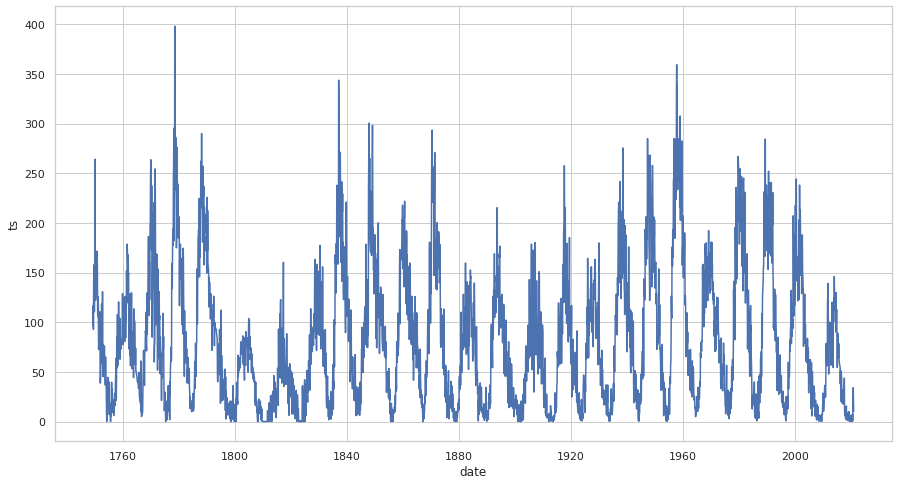

In [12]:
#plot data awal
plt.figure(figsize=(15,8))
sns.lineplot(data=df, x='date', y='ts')

In [30]:
#mengatur data 10 tahun terakhir dengan hitungan 12 bulan per tahun
df1 = df[-50*12:].reset_index(drop=True)
df1.head()

,date,ts
0,1971-02-28,111.8
1,1971-03-31,85.9
2,1971-04-30,101.6
3,1971-05-31,81.5
4,1971-06-30,70.7


In [31]:
df1.shape

(600, 2)

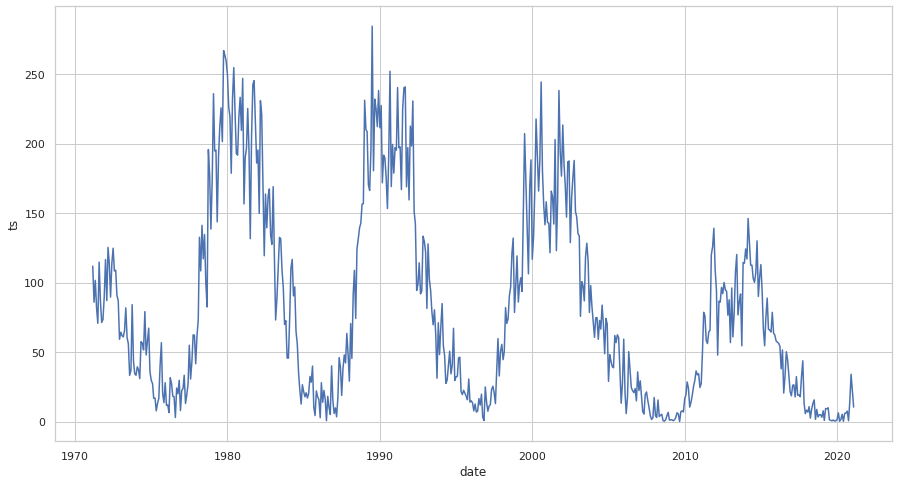

In [32]:
#plot df1 atau data !) TAHUN TERAKHIR
plt.figure(figsize=(15,8))
sns.lineplot(data=df1, x='date', y='ts')

In [33]:
df1.describe()

,ts
count,600.000000
mean,82.061000
std,69.957188
min,0.000000
25%,21.375000
50%,63.500000
75%,127.925000
max,284.500000


In [34]:
# split data
train_size = int(len(df1) * 0.7) # Menentukan banyaknya data train yaitu sebesar 70% data
train = df1[:train_size]
test =df1[train_size:].reset_index(drop=True)

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train[['ts']])

train['scaled'] = scaler.transform(train[['ts']])
test['scaled'] = scaler.transform(test[['ts']])

In [36]:
train.head()

,date,ts,scaled
0,1971-02-28,111.8,0.391687
1,1971-03-31,85.9,0.300458
2,1971-04-30,101.6,0.355759
3,1971-05-31,81.5,0.284959
4,1971-06-30,70.7,0.246918


In [37]:
def sliding_window(data, window_size):
    sub_seq, next_values = [], []
    for i in range(len(data)-window_size):
        sub_seq.append(data[i:i+window_size])
        next_values.append(data[i+window_size])
    X = np.stack(sub_seq)
    y = np.array(next_values)
    return X,y


In [38]:
window_size = 12

X_train, y_train = sliding_window(train[['scaled']].values, window_size)
X_test, y_test = sliding_window(test[['scaled']].values, window_size)


In [39]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(408, 12, 1) (408, 1)
(168, 12, 1) (168, 1)


## LSTM

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM #, RNN, GRU 

In [41]:
def create_model(LSTM_unit=64, dropout=0.2): #jika ingin menggunakan RNN atau GRU ganti LSTM dengan GRU/RNN
    # create model
    model = Sequential()
    model.add(LSTM(units=LSTM_unit, input_shape=(window_size, 1)))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    # Compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [42]:
LSTM_unit = [16,32,64,128]
dropout = [0.1,0.2]


In [43]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping
# Early Stopping
es = EarlyStopping(monitor = 'val_loss', mode = "min", patience = 5, verbose = 0)

# create model
model = KerasRegressor(build_fn=create_model, epochs=50, validation_split=0.1, batch_size=32, callbacks=[es], verbose=1)

# define the grid search parameters
LSTM_unit = [16,32,64,128]
dropout=[0.1,0.2]
param_grid = dict(LSTM_unit=LSTM_unit, dropout=dropout)

In [44]:
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

In [45]:
grid_result = grid.fit(X_train, y_train)

Epoch 1/50
12/12 [==============================] - 3s 60ms/step - loss: 0.0824 - mae: 0.2102 - val_loss: 0.0173 - val_mae: 0.1172
Epoch 2/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0226 - mae: 0.1233 - val_loss: 0.0075 - val_mae: 0.0687
Epoch 3/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0169 - mae: 0.1013 - val_loss: 0.0092 - val_mae: 0.0780
Epoch 4/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0160 - mae: 0.0970 - val_loss: 0.0074 - val_mae: 0.0693
Epoch 5/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0151 - mae: 0.0949 - val_loss: 0.0049 - val_mae: 0.0564
Epoch 6/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0144 - mae: 0.0905 - val_loss: 0.0088 - val_mae: 0.0756
Epoch 7/50
12/12 [==============================] - 0s 9ms/step - loss: 0.0144 - mae: 0.0894 - val_loss: 0.0061 - val_mae: 0.0635
Epoch 8/50
12/12 [==============================] - 0s 10ms/step - loss: 0.0145 - mae: 0

In [46]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    
# Mengambil model terbaik
best_model = grid_result.best_estimator_.model

Best: -0.010502 using {'LSTM_unit': 64, 'dropout': 0.1}
-0.012551 (0.005683) with: {'LSTM_unit': 16, 'dropout': 0.1}
-0.012493 (0.005167) with: {'LSTM_unit': 16, 'dropout': 0.2}
-0.010519 (0.003644) with: {'LSTM_unit': 32, 'dropout': 0.1}
-0.012734 (0.002892) with: {'LSTM_unit': 32, 'dropout': 0.2}
-0.010502 (0.004365) with: {'LSTM_unit': 64, 'dropout': 0.1}
-0.012032 (0.004390) with: {'LSTM_unit': 64, 'dropout': 0.2}
-0.011797 (0.004961) with: {'LSTM_unit': 128, 'dropout': 0.1}
-0.011836 (0.005228) with: {'LSTM_unit': 128, 'dropout': 0.2}


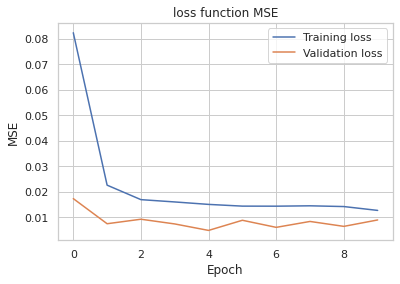

In [47]:
history = best_model.history
# grafik loss function MSE

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('loss function MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend()

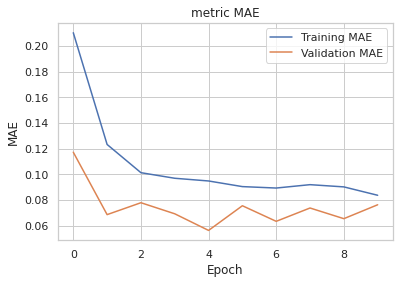

In [48]:
# grafik metric MAE

plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('metric MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()

In [49]:
# Prediksi data train
predict_train = scaler.inverse_transform(best_model.predict(X_train))
true_train = scaler.inverse_transform(y_train)

# Prediksi data test
predict_test = scaler.inverse_transform(best_model.predict(X_test))
true_test = scaler.inverse_transform(y_test)

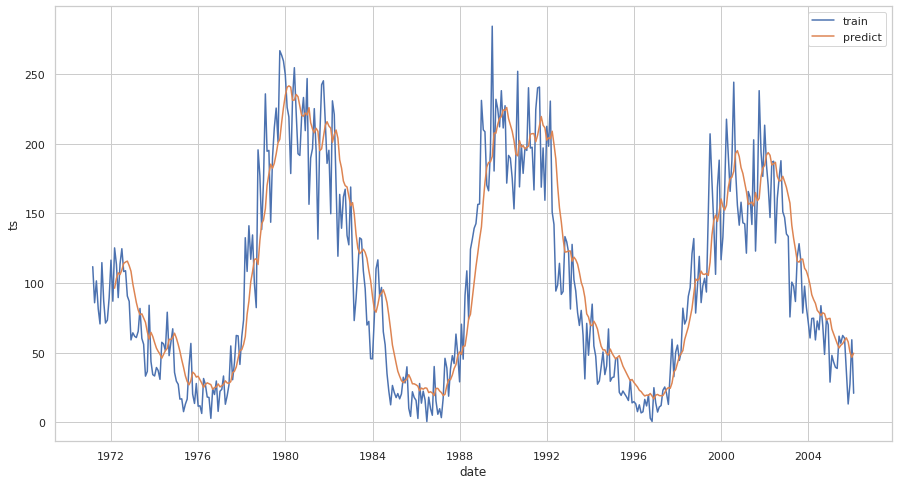

In [52]:
train['predict'] = np.nan
train['predict'][-len(predict_train):] = predict_train[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=train, x='date', y='ts', label = 'train')
sns.lineplot(data=train, x='date', y='predict', label = 'predict')

plot prediksi data test

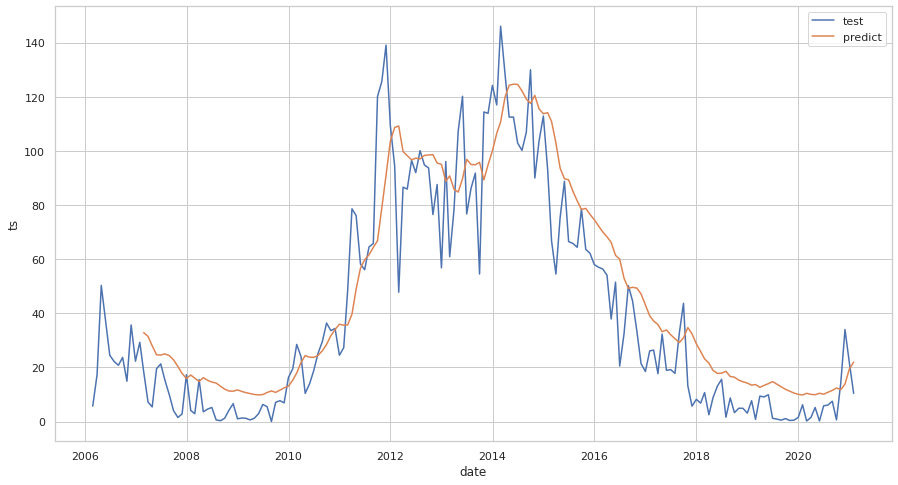

In [54]:
test['predict'] = np.nan
test['predict'][-len(predict_test):] = predict_test[:,0]

plt.figure(figsize=(15,8))
sns.lineplot(data=test, x='date', y='ts', label = 'test')
sns.lineplot(data=test, x='date', y='predict', label = 'predict')

plot prediksi data test 5 tahun terakhir

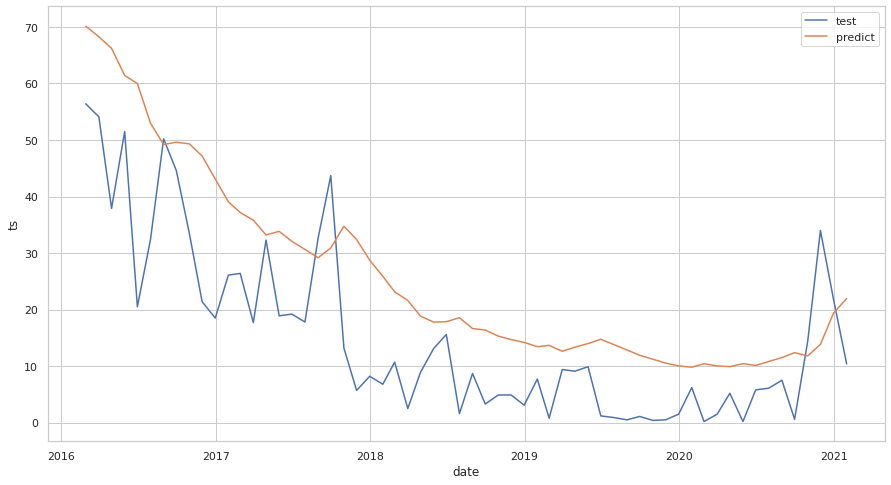

In [55]:
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-5*12:], x='date', y='ts', label = 'test')
sns.lineplot(data=test[-5*12:], x='date', y='predict', label = 'predict')

melakukan Forecasting

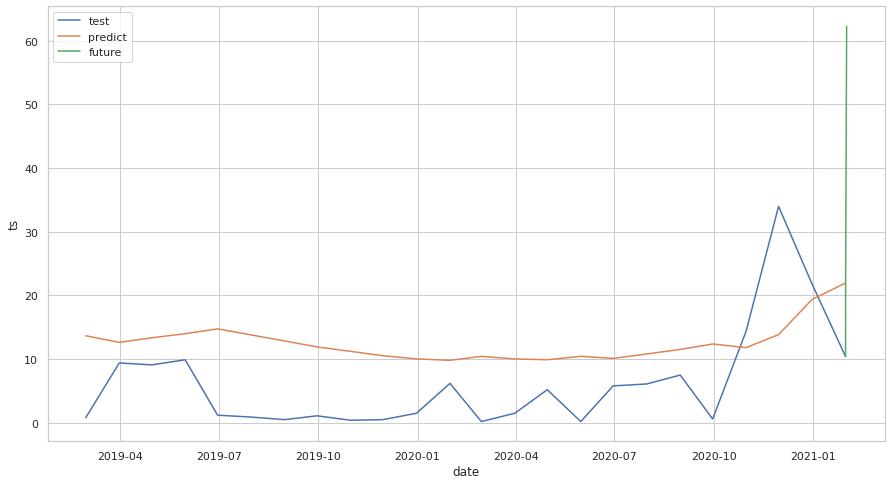

In [60]:
# forecasting data selanjutnya
y_test = scaler.transform(test[['ts']])
n_future = 2*12
future = [[y_test[-1,0]]]
X_new = y_test[-window_size:,0].tolist()

for i in range(n_future):
    y_future = best_model.predict(np.array([X_new]).reshape(1,window_size,1))
    future.append([y_future[0,0]])
    X_new = X_new[1:]
    X_new.append(y_future[0,0])

future = scaler.inverse_transform(np.array(future))
date_future = pd.date_range(start=test['date'].values[-1], periods=n_future+1, freq='H')
# Plot Data sebulan terakhir dan seminggu ke depan
plt.figure(figsize=(15,8))
sns.lineplot(data=test[-12*2:], x='date', y='ts', label = 'test')
sns.lineplot(data=test[-12*2:], x='date', y='predict', label = 'predict')
sns.lineplot(x=date_future, y=future[:,0], label = 'future')
plt.ylabel('ts');
